In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()


In [10]:
import pandas as pd
letter_df = pd.read_csv('letterdata.csv')

In [11]:
letter_df.head()

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [12]:
letter_df.shape

(20000, 17)

In [13]:
import pandas as pd
y_vals = pd.get_dummies(letter_df['letter'])

In [14]:
import pandas as pd

x_vals = np.array([x[1:] for x in letter_df.values])
y_vals = pd.get_dummies(letter_df['letter']).values


In [15]:
y_vals

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
# Create graph session 
sess = tf.Session()

In [17]:
# Set Seed
seed = 3
tf.set_random_seed(seed)
np.random.seed(seed)

In [18]:
# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [19]:
print(x_vals_train.shape)
print(x_vals_test.shape)
print(y_vals_train.shape)
print(y_vals_test.shape)

(16000, 16)
(4000, 16)
(16000, 26)
(4000, 26)


In [20]:
# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))


In [21]:
# Declare batch size
batch_size = 50

In [22]:
# Initialize placeholders
x_data = tf.placeholder(shape=[None, 16], dtype=tf.float32)
y_target = tf.placeholder(shape=[None,26], dtype=tf.float32)

In [23]:
# Create variables for both Neural Network Layers
hidden_layer_nodes = 30
A1 = tf.Variable(tf.random_normal(shape=[16,hidden_layer_nodes])) # inputs -> hidden nodes
b1 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes]))   # one biases for each hidden node
A2 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes,26])) # hidden inputs -> 1 output
b2 = tf.Variable(tf.random_normal(shape=[26]))   # 1 bias for the output

In [24]:

# Declare model operations
hidden_output = tf.nn.relu(tf.add(tf.matmul(x_data, A1), b1))
final_output = tf.nn.relu(tf.add(tf.matmul(hidden_output, A2), b2), name="op_to_restore")

In [25]:
# Declare loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(final_output, y_target))

In [26]:
# Declare optimizer
my_opt = tf.train.MomentumOptimizer(learning_rate=0.00005, momentum=0.9)
train_step = my_opt.minimize(loss)

In [27]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [28]:
# Training loop
loss_vec = []
test_loss = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    #print(rand_x)
    #print(rand_x.shape)
    rand_y = y_vals_train[rand_index]
    #print(rand_y.shape)
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    #print(temp_loss)
    loss_vec.append(np.sqrt(temp_loss))
    
    test_temp_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: y_vals_test})
    test_loss.append(np.sqrt(test_temp_loss))
    if (i+1)%50==0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))


Generation: 50. Loss = 86.98853
Generation: 100. Loss = 28.053041
Generation: 150. Loss = 12.829755
Generation: 200. Loss = 5.5849347
Generation: 250. Loss = 4.6578236
Generation: 300. Loss = 3.8837457
Generation: 350. Loss = 2.1860998
Generation: 400. Loss = 2.0660472
Generation: 450. Loss = 1.267887
Generation: 500. Loss = 1.3936229


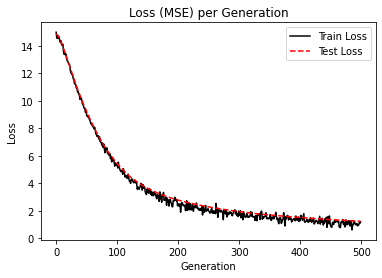

'my_NN_model-450'

In [29]:
# Plot loss (MSE) over time
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

saver = tf.train.Saver()



saver.save(sess, "model.ckpt")

saver.save(sess, 'my_NN_model',global_step=450)